# SOL price prediction

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('SOL-USD.csv')

In [3]:
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-10,0.832005,1.313487,0.694187,0.951054,0.951054,87364276
1,2020-04-11,0.951054,1.049073,0.765020,0.776819,0.776819,43862444
2,2020-04-12,0.785448,0.956670,0.762426,0.882507,0.882507,38736897
3,2020-04-13,0.890760,0.891603,0.773976,0.777832,0.777832,18211285
4,2020-04-14,0.777832,0.796472,0.628169,0.661925,0.661925,16747614


### Adding features

In [4]:
year = []
month=[]
day=[]
for i in data['Date'].values:
    x = i.split('-')
    year.append(int(x[0]))
    month.append(int(x[1]))
    day.append(int(x[2]))
data['Year'] = year
data['Month'] = month
data['Day'] = day

In [5]:
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
872,2022-08-30,32.460041,33.072636,30.796524,31.412056,31.412056,861409804,2022,8,30
1055,2023-03-01,21.912136,22.795338,21.738678,22.506432,22.506432,346532018,2023,3,1
288,2021-01-23,3.341035,3.597302,3.315762,3.504112,3.504112,27904470,2021,1,23
91,2020-07-10,0.853304,0.939629,0.842850,0.913560,0.913560,1856095,2020,7,10
542,2021-10-04,172.961624,172.961624,162.773331,166.731918,166.731918,3109040100,2021,10,4


In [6]:
data['Date']=pd.to_datetime(data['Date'])

In [7]:
# prev_score give us the difference between the highest price and the lowest price
data['Prev_close'] = data['Close'].shift(1)
data.dropna(axis=0,inplace=True)
# delta_hl give us the difference between the highest and the actual close
data['delta_hl'] = data['High'] - data['Low']

In [8]:
train = data[data['Date'] <= pd.datetime(2022,12,31,23,59)]
test = data[data['Date'] >= pd.datetime(2022,12,31,23,59)]

C:\Users\DELL\AppData\Local\Temp\ipykernel_4844\1666691955.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  train = data[data['Date'] <= pd.datetime(2022,12,31,23,59)]
C:\Users\DELL\AppData\Local\Temp\ipykernel_4844\1666691955.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  test = data[data['Date'] >= pd.datetime(2022,12,31,23,59)]


### Visualisation

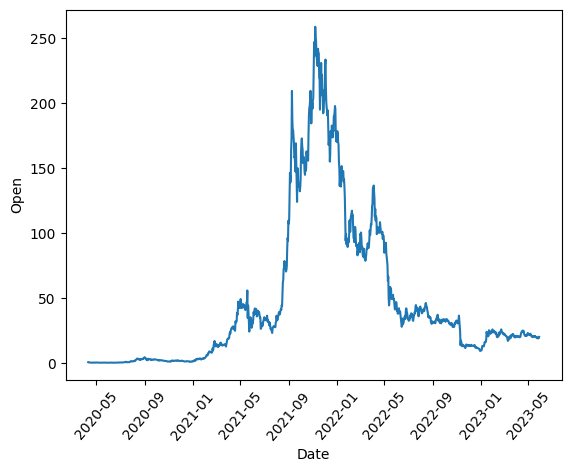

In [9]:
sns.lineplot(data,x='Date',y='Open')
plt.xticks(rotation = 50)
plt.show()      

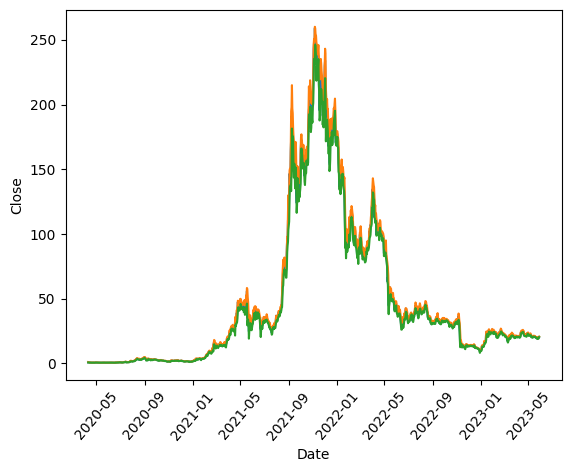

In [10]:
sns.lineplot(data,x='Date',y='Close')
sns.lineplot(data,x='Date',y='High')
sns.lineplot(data,x='Date',y='Low')
plt.xticks(rotation = 50)
plt.show()      

In [11]:
true_test = test['Close']

In [12]:
train.drop('Date',axis=1,inplace=True)
test.drop('Date',axis=1,inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_4844\565370736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('Date',axis=1,inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_4844\565370736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('Date',axis=1,inplace=True)


### Model

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import metrics

In [14]:
y=train['Close']
x=train.drop('Close',axis=1,inplace=False)
train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 40)
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(test_y,pred))

RMSE :  2.663965
R squared:  0.9978645064989152


In [15]:
tst = test.drop('Close',axis=1,inplace=False)
tst=tst.to_numpy()

In [16]:
pred=xgb_r.predict(tst)
rmse = np.sqrt(MSE(true_test, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(true_test,pred)) 

RMSE :  1.911361
R squared:  0.5461454681001239


### Optimisation

In [17]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = k)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 40, seed = 0)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(200)
m=c.index(min(c))
m

141

In [18]:
def accuracy(k):    
    train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 141)
    xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = k, seed = 0)
    xgb_r.fit(train_X, train_y)
    pred = xgb_r.predict(test_X)
    rmse = np.sqrt(MSE(test_y, pred))
    return rmse
def best_rd(x):
    d=[]
    for i in range(0,x+1):
        d.append(accuracy(i))
    return d
c =best_rd(100)
m=c.index(min(c))
m

35

### Score and Evaluation

In [21]:
y=train['Close']
x=train.drop('Close',axis=1,inplace=False)
train_X, test_X, train_y, test_y = train_test_split(x, y,test_size = 0.3, random_state = 141)
xgb_r = xgb.XGBRegressor(objective ='reg:tweedie',n_estimators = 35, seed = 0)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(test_y,pred))

RMSE :  0.804165
R squared:  0.9998163864303009


In [22]:
pred=xgb_r.predict(tst)
rmse = np.sqrt(MSE(true_test, pred))
print("RMSE : % f" %(rmse))
print("R squared: ", metrics.r2_score(true_test,pred)) 

RMSE :  1.035343
R squared:  0.8668320002695041


In [23]:
comparaison = pd.DataFrame()
x = true_test.values

In [24]:
comparaison['Predictions'] = pred
comparaison['True_test'] = x

In [25]:
comparaison

,Predictions,True_test
0,10.135611,9.982173
1,11.671333,11.272967
2,13.444593,13.344046
3,13.649912,13.435113
4,13.625743,13.419330
...,...,...
143,19.109608,19.223663
144,19.141953,19.260662
145,21.369129,19.366957
146,21.415232,20.425234


<Axes: xlabel='Predictions', ylabel='True_test'>

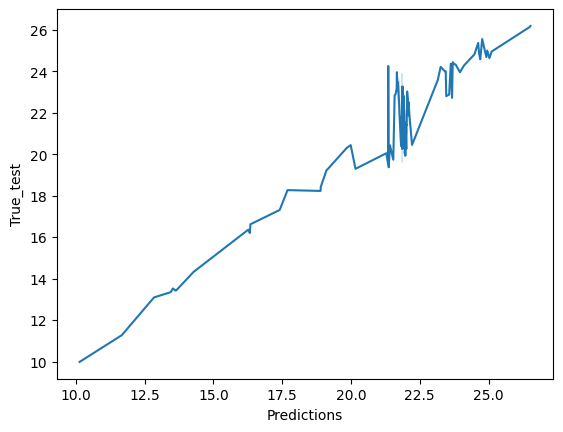

In [26]:
sns.lineplot(comparaison,x='Predictions',y='True_test')

In [27]:
import pickle
with open('sol_regressor','wb') as f:
    pickle.dump(xgb_r,f)